In [24]:
import pandas as pd
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# Load and clean the data

In [25]:
orig_df = pd.read_csv("datasets/monthly_in_situ_co2_mlo.csv")
orig_df.columns = orig_df.columns.str.strip()
orig_df.drop([0, 1], inplace=True)
orig_df = orig_df.loc[:,~orig_df.columns.duplicated()]
orig_df.drop('Date', axis=1, inplace=True)
orig_df['Date'] = pd.to_datetime(orig_df[['Yr', 'Mn']].rename(columns={'Yr': 'year', 'Mn': 'month'}).assign(day=1))
orig_df.set_index('Date', inplace=True)
orig_df.head()

,Yr,Mn,CO2,seasonally,fit,Sta
Date,,,,,,
1958-01-01,1958,01,-99.99,-99.99,-99.99,MLO
1958-02-01,1958,02,-99.99,-99.99,-99.99,MLO
1958-03-01,1958,03,315.71,314.44,316.20,MLO
1958-04-01,1958,04,317.45,315.16,317.30,MLO
1958-05-01,1958,05,317.51,314.69,317.89,MLO


# Further clean and plot the data

<Axes: xlabel='Date'>

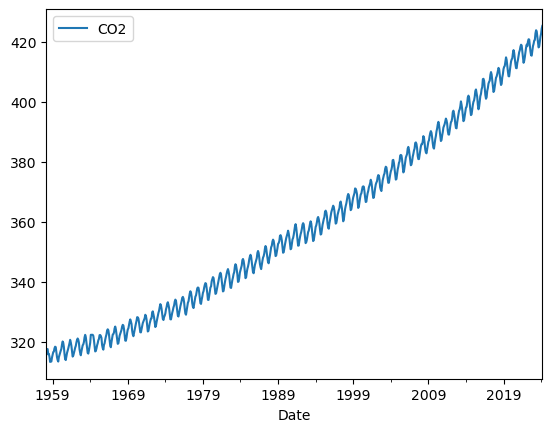

In [26]:
df = orig_df['CO2']
df = pd.to_numeric(df, errors='coerce')
df = df.to_frame()
df['CO2'] = df['CO2'].replace(-99.99, np.nan)
df = df[2:-9]
df.bfill(inplace=True)
df.plot()

# Create lagged features

In [27]:
for i in range(12,0,-1):
    df['t='+str(i)] = df['CO2'].shift(i)
df.dropna(inplace=True)

# Prepare the training and test dataset

In [28]:
X = df.drop('CO2', axis=1)
y = df['CO2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Find the optimum parameters for the RFR using Grid Search and evaluate the model

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'max_depth': 10, 'max_features': None, 'n_estimators': 300}
Best score: -0.0014670110726699634


In [30]:
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)*100

0.1293016996892892

# Plot the actual vs predicted values

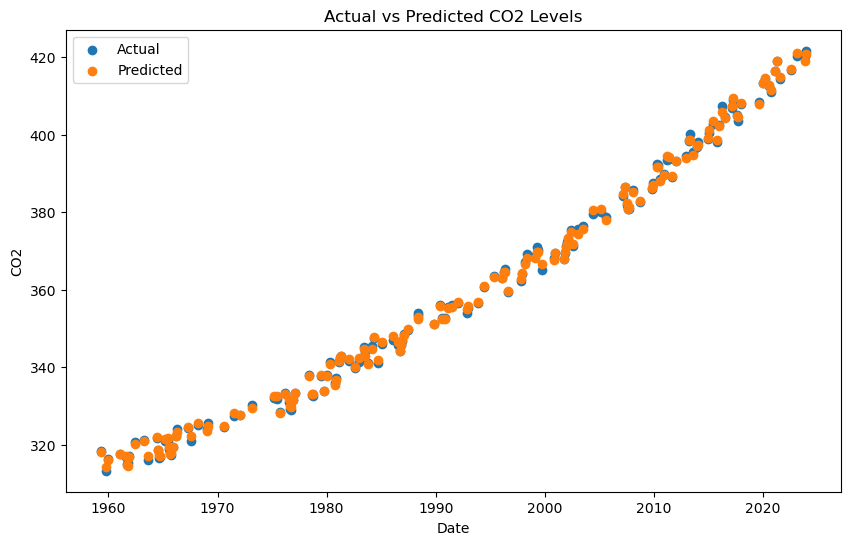

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test.values, label='Actual')
plt.scatter(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

# Evaluate the predictions of the last 12 months of the data

In [32]:
def get_first_eval_batch(data, n):
    return data[-n:].reshape(-1, n)

def make_predictions(train_data, test_data, model, lag_count = 12):
    test_prediction_rfr = []
    current_batch = get_first_eval_batch(train_data, lag_count)

    for i in range(len(test_data)):
        current_batch_df = pd.DataFrame(current_batch, columns=X_train.columns)
        current_pred = model.predict(current_batch_df)[0]
        test_prediction_rfr.append(current_pred)
        current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, lag_count)
    return test_prediction_rfr

train = df[:-12]
test = df[-12:]

test_prediction_rfr = make_predictions(train["CO2"].values, test, model)

print(test_prediction_rfr)

[422.7042666666656, 423.48343333333247, 423.0289666666659, 421.6359266666651, 419.5179923809514, 418.334773333332, 418.42078388888734, 418.999894999999, 420.660891666665, 422.1299666666655, 424.0395333333344, 424.25153333333367]


<Axes: xlabel='Date'>

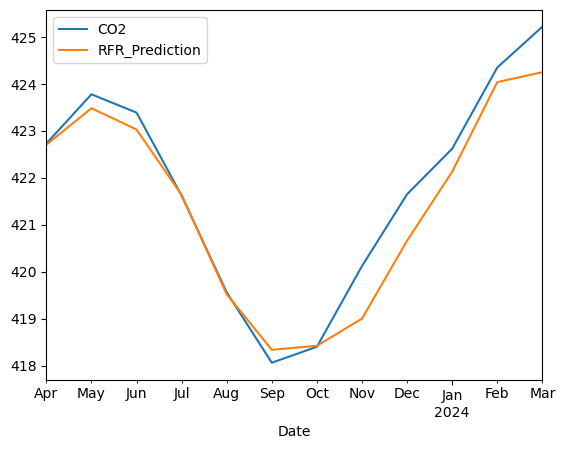

In [33]:
df_comp = test["CO2"].to_frame()
df_comp["RFR_Prediction"] = test_prediction_rfr
df_comp.plot()

# Find optimal params for Gradient Boosting Regressor

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 3, 5, 10]
}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
gb_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best score: -0.001501755995488788


# Evaluate the model's performance

In [35]:
y_pred = gb_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)*100
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Absolute Percentage Error: 0.1353251251816036%


# Plot the actual vs predicted values

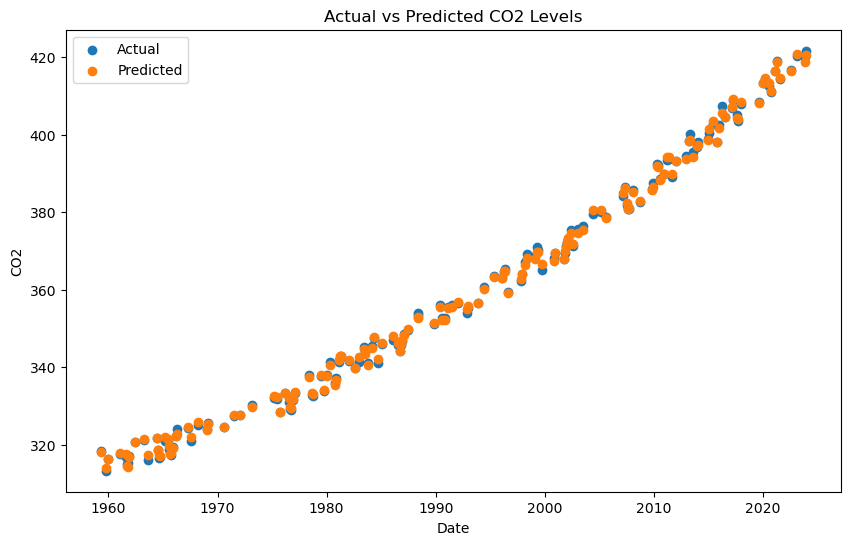

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test.values, label='Actual')
plt.scatter(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

# Evaluate the predictions of the last 12 months of the data

<Axes: xlabel='Date'>

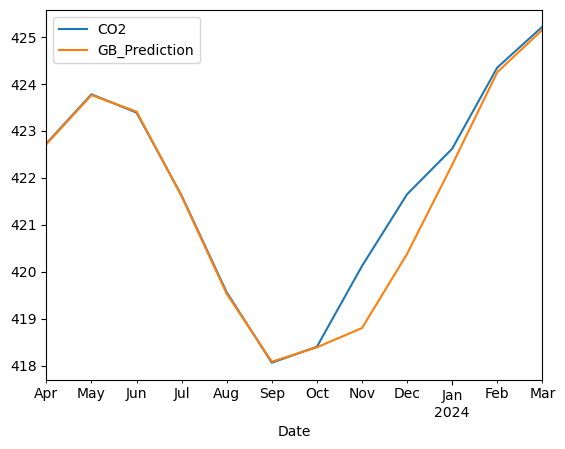

In [37]:
test_prediction_gb = make_predictions(train["CO2"].values, test, gb_model)

df_comp = test["CO2"].to_frame()
df_comp["GB_Prediction"] = test_prediction_gb
df_comp.plot()

# Find optimal params for XGBoost Regressor

In [39]:
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 3, 5, 10]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
xgb_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best score: -0.0016926395170253686


# Evaluate the model's performance

In [40]:
y_pred = xgb_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)*100
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Absolute Percentage Error: 0.14795268566821135%


# Plot the actual vs predicted values

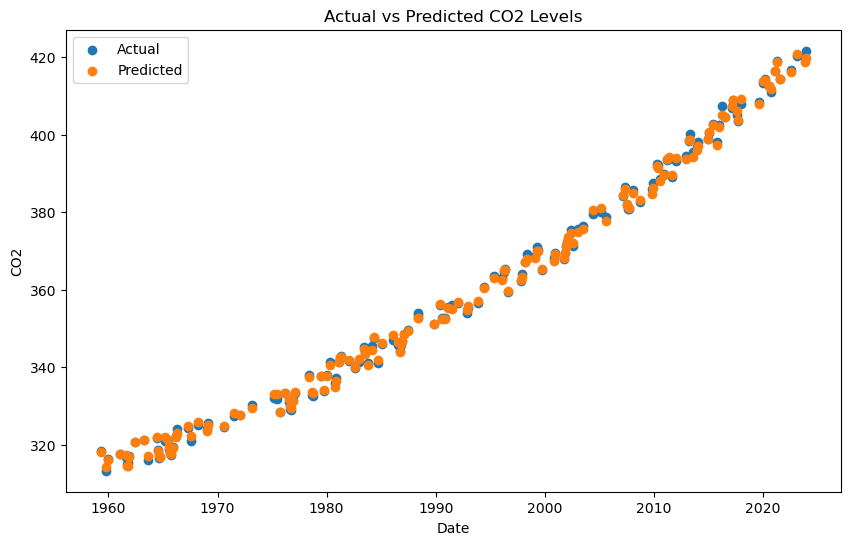

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test.values, label='Actual')
plt.scatter(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

# Evaluate the predictions of the last 12 months of the data

<Axes: xlabel='Date'>

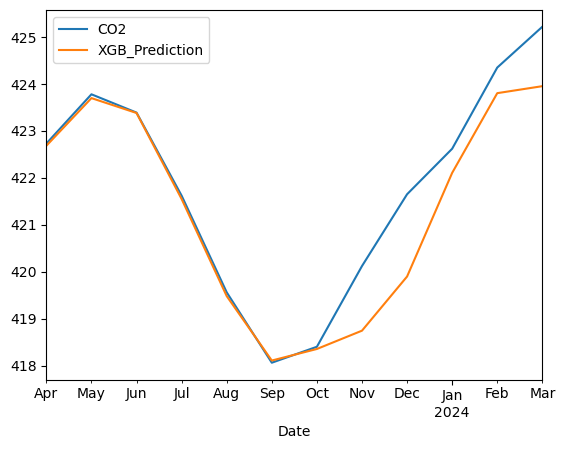

In [42]:
test_prediction_xgb = make_predictions(train["CO2"].values, test, xgb_model)

df_comp = test["CO2"].to_frame()
df_comp["XGB_Prediction"] = test_prediction_xgb
df_comp.plot()

# Conclusion
The Random Forest Regressor model was the best performing model with a Mean Absolute Percentage Error of 0.13%. The model was able to predict the CO2 levels for the last 12 months with a high degree of accuracy.